# Project 3
## Q5 Model-based collaborative ﬁltering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import SVD, evaluate
from surprise import NMF
from surprise.model_selection import cross_validate

In [2]:

ratings = pd.read_csv('ratings.csv') # reading data in pandas df
from surprise import Reader, Dataset
# to load dataset from pandas df, we need `load_fromm_df` method in surprise lib
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}
df = pd.DataFrame(ratings_dict)
# A reader is still needed but only the rating_scale param is required.
# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(0.5, 5.0))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader) 

## 5.2.2 Design and test via cross-validation

In [3]:
NNMF_RMSE=[];
NNMF_MAE=[];
latent_factors=np.arange(2,51,2)
print("doing cross validation...")
for k in latent_factors:
    algo=NMF(n_factors=k,biased=False,random_state=42)
    cv_results=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False);
    NNMF_RMSE.append(np.mean(cv_results['test_rmse']))
    NNMF_MAE.append(np.mean(cv_results['test_mae']))

print("cross validation completed")  

doing cross validation...
cross validation completed


### Q17 Q18

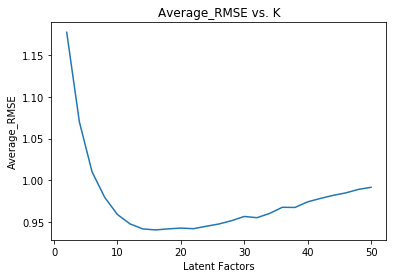

The min average_rmse is 0.940345
corresponding k= 16


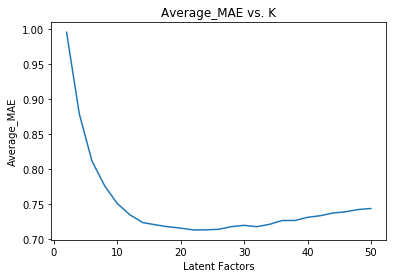

The min average_mae is 0.713612
The corresponding k= 22


In [4]:

plt.plot(latent_factors,NNMF_RMSE)
plt.xlabel('Latent Factors')
plt.ylabel('Average_RMSE')
plt.title('Average_RMSE vs. K')
plt.show()
print("The min average_rmse is %6f" %min(NNMF_RMSE))
index_min=np.argmin(NNMF_RMSE)
k_value=latent_factors[index_min]
print("corresponding k= %d"%k_value)
#min average_rmse is 0.937430697493, k=18

plt.plot(latent_factors,NNMF_MAE)
plt.xlabel('Latent Factors')
plt.ylabel('Average_MAE')
plt.title('Average_MAE vs. K')
plt.show()
print("The min average_mae is %6f" %min(NNMF_MAE))
index_min=np.argmin(NNMF_MAE)
k_value=latent_factors[index_min]
print("The corresponding k= %d"%k_value)


## 5.2.3 NNMF ﬁlter performance on trimmed test set

In [5]:
from surprise import accuracy
from surprise.model_selection import KFold
from collections import defaultdict

def trimming_function(trim_method, test_data_set):
    #build a dictionary to store the movieID and corrsponding ratings
    # rating_dict[movieID]=the list of its ratings     
    trimmed=[] 
    rating_dict=defaultdict(list)
    for i in range(len(test_data_set)):
        rating_dict[test_data_set[i][1]].append(test_data_set[i][2])
    
    if(trim_method=='Popular'):
        for i in range(len(test_data_set)):
            if(len(rating_dict[test_data_set[i][1]])>2):
                trimmed.append(test_data_set[i])
                
    elif(trim_method=='Unpopular'):
        for i in range(len(test_data_set)):
            if(len(rating_dict[test_data_set[i][1]])<=2):
                trimmed.append(test_data_set[i])   
                
    elif(trim_method=='High_variance'):          
        # test the variance of each movie ratings, remove the movie from dict if variance<2
        for i in range(len(test_data_set)):
            if(len(rating_dict[test_data_set[i][1]])<5 or np.var(rating_dict[test_data_set[i][1]])<2):
                del rating_dict[test_data_set[i][1]]
                
        for i in range(len(test_data_set)):
            if(test_data_set[i][1] in list(rating_dict.keys())):
                trimmed.append(test_data_set[i])
    else:
        print('ERROR!')
        return
        
    return trimmed

def NNMF_cross_validation_function(data_set,latent_factor,trim_method):
    kf=KFold(n_splits=10,random_state=42)
    algo=NMF(n_factors=latent_factor, biased=False,random_state=42)
    RMSE_set=[]
    for trainset, testset in kf.split(data_set):
        algo.fit(trainset)
        trimmed_testset=trimming_function(trim_method, testset)
        predictions=algo.test(trimmed_testset)
        RMSE_set.append(accuracy.rmse(predictions, verbose=False))
        
    Average_RMSR=np.mean(RMSE_set)
    return Average_RMSR
    

def NNMF_RMSE_plot(latent_factors, NNMF_RMSE, trim_method):
    print('NNMF polt for %s movies trimmed test set'% trim_method)
    plt.plot(latent_factors,NNMF_RMSE)
    plt.xlabel('Latent Factors')
    plt.ylabel('Average_RMSE')
    plt.title('Average_RMSE vs. K')
    plt.show()
    print("The min average_rmse is %6f" %min(NNMF_RMSE))
    min_index=np.argmin(NNMF_RMSE)
    lf=latent_factors[min_index]
    print("The corresponding k= %d" %lf)
    print('')

### Q19 20 21

Doing NNMF filter on Popular movies trimmed test set....
NNMF polt for Popular movies trimmed test set


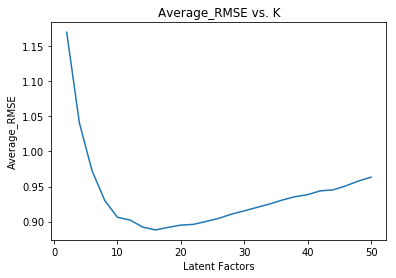

The min average_rmse is 0.888225
The corresponding k= 16

Doing NNMF filter on Unpopular movies trimmed test set....
NNMF polt for Unpopular movies trimmed test set


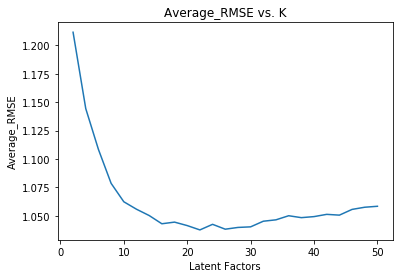

The min average_rmse is 1.037476
The corresponding k= 22

Doing NNMF filter on High_variance movies trimmed test set....
NNMF polt for High_variance movies trimmed test set


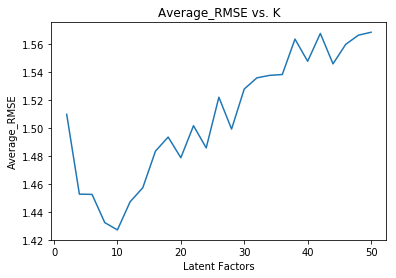

The min average_rmse is 1.427234
The corresponding k= 10



In [6]:
latent_factors=np.arange(2,51,2)
trimming_operations=['Popular','Unpopular','High_variance']
for method in trimming_operations:
    print("Doing NNMF filter on %s movies trimmed test set...." %method)
    Average_RMSR_set=[]
    for k in latent_factors:
        Average_RMSR_set.append(NNMF_cross_validation_function(data,k,method))
        
    NNMF_RMSE_plot(latent_factors,Average_RMSR_set,method)


# 5.2.4 Performance evaluation using ROC curve

In [7]:
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
import os
from surprise.model_selection import train_test_split
# path to dataset file
file_path = os.path.expanduser('C:/python/EE219/project3/ratings.csv')
# 'user item rating timestamp', separated by ',' characters. skip the first line with header
reader = Reader(line_format='user item rating timestamp', sep=',',skip_lines=1)
#split the dataset into 90% for training and 10% for testing
data = Dataset.load_from_file(file_path, reader=reader)

train_set, test_set = train_test_split(data, test_size=0.1)
algo=NMF(n_factors=20,biased=False,random_state=42)
algo.fit(train_set)
predictions = algo.test(test_set)

In [8]:
test_target_group = []
score_test = []
for (_, _, true_r, est, _) in predictions:
    test_target_group.append(true_r)
    score_test.append(est)
    
def threshold_target(threshold,test_target_group):
    aft_test = []
    for i in test_target_group:
        if i>= threshold: k = 1
        else: k=0
        aft_test.append(k)
    return aft_test


### Q22

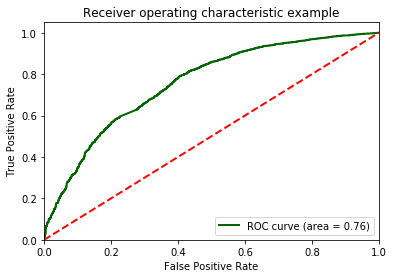

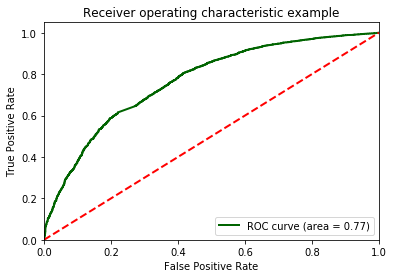

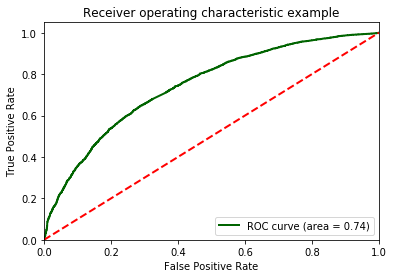

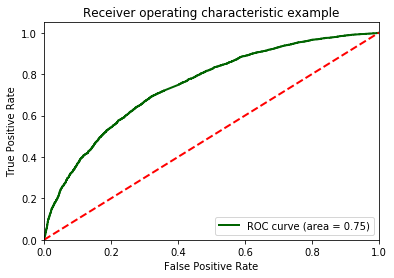

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# calculate ROC curve and ROC area for each class


def plot_roc(fpr, tpr):   
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkgreen',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

for threshold in [2.5,3,3.5,4]:
    aft_test = threshold_target(threshold,test_target_group)
    fpr = dict()
    tpr = dict()
    fpr, tpr, thresholds = roc_curve(aft_test, score_test)
    plot_roc(fpr, tpr)

## 5.2.5 Interpretability of NNMF

In [10]:
from surprise import Dataset
from surprise import Reader
import os

# path to dataset file
file_path = os.path.expanduser('C:/python/EE219/project3/ratings.csv')
# 'user item rating timestamp', separated by ',' characters. skip the first line with header
reader = Reader(line_format='user item rating timestamp', sep=',',skip_lines=1)
#split the dataset into 90% for training and 10% for testing
data = Dataset.load_from_file(file_path, reader=reader)
trainset = data.build_full_trainset()
algo=NMF(n_factors=20,biased=False,random_state=42)
algo.fit(trainset)
U=algo.pu
V=algo.qi
print(V.shape)

In [ ]:
# path to dataset file
file_path = os.path.expanduser('C:/python/EE219/project3/movies.csv')

reader = Reader(line_format='movieId title genres', sep=',',skip_lines=1)
movie_data = Dataset.load_from_file(file_path, reader=reader)

movies = pd.read_csv('movies.csv') # reading data in pandas df

# to load dataset from pandas df, we need `load_fromm_df` method in surprise lib
movies_dict = {'movieID': list(movies.movieId),
                'title': list(movies.title),
                'genres': list(movies.genres)}


### Q23